# Hadean Volcanic Outgassing
The following code calculates plausible outgassing rates of several volcanic gases on the Hadean Earth. The outgassing rates calculated in this code (outputed as a .txt file) is used later in the photochemical simulation.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import sys

# import custum thermodynamics functions
sys.path.append('/')
from thermodynamics import *

In [2]:
# Solving for thermodynamic constants. Here I will use values for T = 1473k
# from Holland 1984. 

T = 1473 #kelvin
P = 5 #bar
R = 8.314 # ideal gas constant

DG_r1 = (gibbsG('H2  ',T)+0.5*gibbsG('O2  ',T))-gibbsG('H2O ',T)
K1 = np.exp(-DG_r1/(R*T))

DG_r2 = (gibbsG('CO  ',T)+0.5*gibbsG('O2  ',T))-gibbsG('CO2 ',T)
K2 = np.exp(-DG_r2/(R*T))

DG_r3 = (gibbsG('CH4  ',T)+2*gibbsG('O2  ',T))-2*gibbsG('H2O ',T)-gibbsG('CO2 ',T)
K3 = np.exp(-DG_r3/(R*T))

DG_r4 = (gibbsG('H2S  ',T)+1.5*gibbsG('O2  ',T))-gibbsG('H2O ',T)-gibbsG('SO2 ',T)
K4 = np.exp(-DG_r4/(R*T))

print(K1)
print(K2)
print(K3)
print(K4)

1.3068535229178077e-06
3.235012445676783e-06
4.493154054061984e-29
5.531556216717863e-15


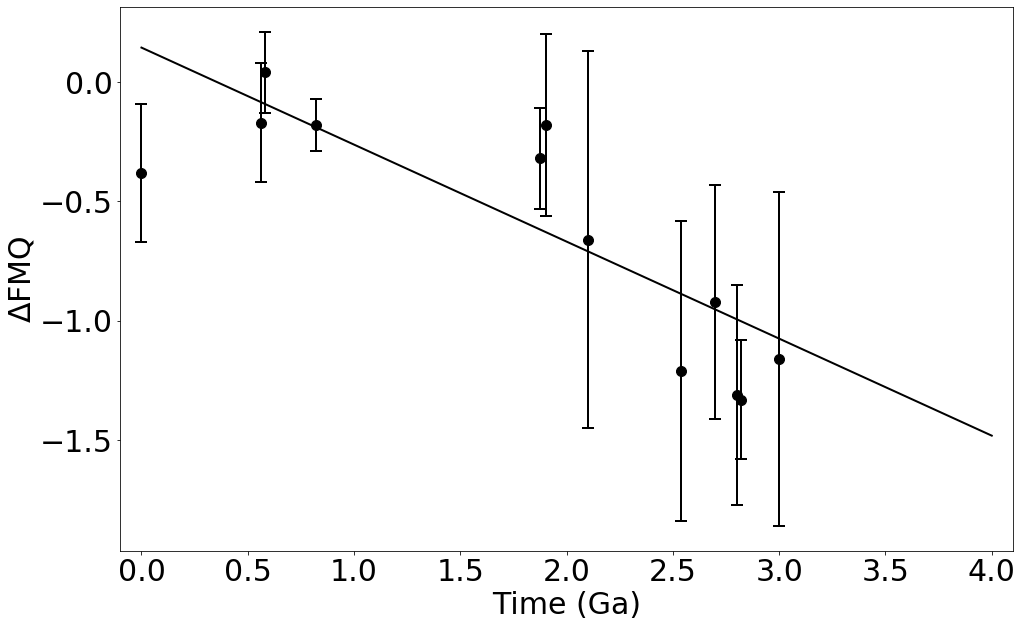

In [3]:
# Oxygen Fugacity
data = np.loadtxt('Data/O2_fugacity.txt',skiprows=1) # data from Aulbach and Stagno (2016)
t = data[:,0]/1000
ind = np.argsort(t)
t = np.sort(t)
ttt = np.linspace(0,4,2)

data = data[ind]
FMQ = data[:,1]
err = data[:,2]
m0, b0 = np.polyfit(t,FMQ,1,w=1/err) # linear fit of data
fit = ttt*m0+b0

A = 25738
B = 9
C = 0.092
FMQ_norm = -A/T+B+C*(P-1)/T

b = b0
m = m0

def O2_fugacity(t):
    # fuction for O2 fugacity through time.
    # t is in billions of years
    val = -8.5 + (m*t+b)
    return 10**val

# plotting Oxygen fugacity data from Aulbach and Stagno (2016) and linear fit
fig,ax = plt.subplots(1,1,figsize=[16,10])
fnt = 30
ax.errorbar(t,FMQ,mfc='black',
         mec='black',ecolor='black',yerr=err,fmt='o',elinewidth=2,capsize=6,capthick=2,markersize=10)
ax.set_xlim(-.1,4.1)
ax.plot(ttt,fit,'k',linewidth=2)
ax.set_xlabel('Time (Ga)',fontsize=fnt)
ax.set_ylabel(r'$\Delta$FMQ',fontsize=fnt)
ax.tick_params(axis='both', which='major', labelsize=fnt)
#plt.savefig("O2_fugacity.pdf",bbox_inches='tight')

# set O2 fugacity at 4 Ga
hadean_O2_fug = 10**(FMQ_norm+fit[-1])

plt.show()

In [4]:
# Listing modern flux data. Modern
# data from Catling and Kasting 2017. units Tmol/yr
F_CO2_mod = 8.5
F_SO2_mod = 1.8
F_H2O_mod = 95
F_H2_mod = 2.0
F_CO_mod = 0.25
F_CH4_mod = 0
F_H2S_mod = 0.03

# Calculate total carbon in the modern
F_c_mod = F_CO2_mod + F_CO_mod + F_CH4_mod
F_s_mod = F_H2S_mod + F_SO2_mod
F_h_mod = F_H2_mod + F_H2O_mod + 2*F_CH4_mod + F_H2S_mod

print(F_c_mod)
print(F_h_mod)
print(F_s_mod)

# calculate ratios

chi_C = F_c_mod/F_h_mod
chi_S = F_s_mod/F_h_mod
print()

print(chi_C)
print(chi_S)

8.75
97.03
1.83

0.09017829537256518
0.01886014634649078


In [5]:
# The system of equations that I need to solve for pressures
def system_equations(array):
        PH2,PH2O,PCO2,PCO,PCH4,PSO2,PH2S = array
        C1 = K1/f_O2**0.5
        C2 = K2/f_O2**0.5
        C3 = K3/f_O2**2
        C4 = K4/f_O2**1.5
        return (PH2+PH2O+PCO2+PCO+PCH4+PSO2+PH2S-P, \
                PH2-C1*PH2O, \
                PCO-C2*PCO2, \
                PCH4-(PH2O)**2*C3*PCO2, \
                PH2S-PH2O*C4*PSO2, \
                (PCO2+PCO+PCH4)-chi_C*(PH2+PH2O+2*PCH4+PH2S), \
                (PH2S+PSO2)-chi_S*(PH2+PH2O+2*PCH4+PH2S))

Below is the solution to the system of equations. I used Mathematica to simplfy the system into a single polynomial in terms of $P_{\mathrm{H_2O}}$ (see file called "volcanism_algebra.nb"). I then use the np.roots function to solve for $P_{\mathrm{H_2O}}$, which can be used to solve for the rest of the variables.

In [6]:
def pressures():
    # constants
    C1 = K1/f_O2**0.5
    C2 = K2/f_O2**0.5
    C3 = K3/f_O2**2
    C4 = K4/f_O2**1.5

    # giant polynomial for P_H2O. Imported from mathematica
    coef0 = P+C2*P
    coef1 = ( -1 + ( -1 * C1 + ( -1 * C2 + ( -1 * C1 * C2 + ( \
    -1 * chi_C + ( -1 * C1 * chi_C + ( -1 * C2 * chi_C + ( -1 * C1 * C2 * \
    chi_C + ( -1 * chi_S + ( -1 * C1 * chi_S + ( -1 * C2 * chi_S + ( -1 * C1 \
    * C2 * chi_S + ( C4 * P + ( C2 * C4 * P + ( -1 * C4 * chi_S * P + -1 * \
    C2 * C4 * chi_S * P ) ) ) ) ) ) ) ) ) ) ) ) ) ) )
    coef2 = ( ( -1 * C4 + ( -1 * C1 * C4 + ( -1 * C2 * C4 + ( -1 * C1 * C2 * C4 + \
    ( -1 * C4 * chi_C + ( -1 * C1 * C4 * chi_C + ( -1 * C2 * C4 * chi_C + ( \
    -1 * C1 * C2 * C4 * chi_C + ( C3 * P + -2 * C3 * chi_C * P ) ) ) ) ) ) \
    ) ) ) )
    coef3 = ( ( -1 * C3 + ( -1 * C1 * C3 + ( C3 * chi_C + ( C1 * C3 * chi_C + ( -1 \
    * C3 * chi_S + ( -1 * C1 * C3 * chi_S + ( C3 * C4 * P + ( -2 * C3 * C4 \
    * chi_C * P + -1 * C3 * C4 * chi_S * P ) ) ) ) ) ) ) ) )
    coef4 = ( -1 * C3 * C4 + ( -1 * C1 * C3 * C4 + ( C3 * C4 * chi_C + C1 * C3 * \
    C4 * chi_C ) ) )

    polynomial = [coef4,coef3,coef2,coef1,coef0]
    zi = np.roots(polynomial)

    # take the only real non-negative solution
    for i in range(0,len(zi)):
        if np.isreal(zi[i]) and P>np.real(zi[i])>0:
            z = np.real(zi[i])

    P_H2O = z
    # With H2O known, then the system becomes a linear system
    # i'll solve it with linear inversion
    A = np.array([[1,0,0,0,0,0],\
                  [0,1,-C2,0,0,0],\
                  [0,0,-C3*P_H2O**2,1,0,0],\
                  [0,0,0,0,1,-C4*P_H2O],\
                  [-chi_S,0,0,-2*chi_S,1-chi_S,1],\
                  [1,1,1,1,1,1]])
    B = np.array([C1*P_H2O,0,0,0,chi_S*P_H2O,P-P_H2O])
    P_H2, P_CO, P_CO2, P_CH4, P_H2S, P_SO2 = np.linalg.inv(A)@B

    # check for error
    temp = system_equations([P_H2,P_H2O,P_CO2,P_CO,P_CH4,P_SO2,P_H2S])
    error = np.linalg.norm(temp)
    tol = 1e-10
    if error> tol:
        print("Error is high!")
        print(error)
    
    return [P_H2, P_H2O, P_CO2, P_CO, P_CH4, P_SO2, P_H2S]


This function uses simple linear algebra to solve for volcanic fluxes from the partial pressures.

In [7]:
# now for solving for fluxes
def fluxes(P_H2,P_H2O,P_CO2,P_CO,P_CH4,P_SO2,P_H2S,F_c,F_s,F_h):
    # Solve carbon species
    C1 = P_H2/P_H2O
    C2 = P_CO/P_CO2
    C3 = P_CH4/P_CO2
    C4 = P_H2S/P_SO2

    A = np.array([[C2,-1,0,0,0,0,0],\
                  [C3,0,-1,0,0,0,0],\
                  [1,1,1,0,0,0,0],\
                  [0,0,0,C4,-1,0,0],\
                  [0,0,0,1,1,0,0],\
                  [0,0,0,0,0,C1,-1],\
                  [0,0,2,0,1,1,1]])

    B = np.array([0,0,F_c,0,F_s,0,F_h])

    F_CO2,F_CO,F_CH4,F_SO2,F_H2S,F_H2O,F_H2 = np.linalg.inv(A)@B

    return (F_H2, F_H2O, F_CO2, F_CO, F_CH4, F_SO2, F_H2S)

In [12]:
# Calculate inputs for the photochemical model

CCC = np.arange(1,26) #range of outgassing parameters between 0 and 25
CC = 3.743e9 #conversion factor between Tmol and moleclues cm-2 s-1
T = 1473 #kelvin
P = 5 #bar
# Oxygen fugacity
f_O2 = 10**(np.log10(hadean_O2_fug))

# ratios called
#chi_C
#chi_S

# total fluxes modern called
# F_c_mod
# F_s_mod
# F_h_mod

# Calculate partial pressure in the gas phase 
P_H2, P_H2O, P_CO2, P_CO, P_CH4, P_SO2, P_H2S = pressures()

F_H2 = []
F_H2O = []
F_CO2 = []
F_CO = []
F_CH4 = []
F_SO2 = []
F_H2S = []

# for each outgassing scenario (C = 1 to 25) calculate fluxes
for C in CCC:
    
    # Calculate the fluxes
    (F_H2_tmp, F_H2O_tmp, F_CO2_tmp, F_CO_tmp, F_CH4_tmp, F_SO2_tmp, F_H2S_tmp) =\
    fluxes(P_H2,P_H2O,P_CO2,P_CO,P_CH4,P_SO2,P_H2S,C*F_c_mod,C*F_s_mod,C*F_h_mod)
    
    F_H2.append(F_H2_tmp*CC)
    F_H2O.append(F_H2O_tmp*CC)
    F_CO2.append(F_CO2_tmp*CC)
    F_CO.append(F_CO_tmp*CC)
    F_CH4.append(F_CH4_tmp*CC)
    F_SO2.append(F_SO2_tmp*CC)
    F_H2S.append(F_H2S_tmp*CC)

Finally, save the results to a .txt file.

In [13]:
names = ['C','FH2','FCO','FSO2','FH2S']  
f = open('Atmos/Data/volc_photochem_inputs.txt','w')
f.write('     '.join(names)+'\n')
for i in range(0,len(F_H2)):
    f.write('%i' % CCC[i]+' '+'%.3E' % F_H2[i]+' '+'%.3E' % F_CO[i]+' '+'%.3E' % F_SO2[i]+' '+'%.3E' % F_H2S[i]+' '+'\n')

f.close()